### Importamos las librerias que vamos a utilizar

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [3]:
data = pd.read_csv("dataset/data.csv")

In [6]:
data_loud = data.drop(columns=["valence","acousticness" ,"danceability", "energy","instrumentalness","liveness","speechiness","artists","duration_ms","explicit","id","key","mode","name","popularity","release_date","tempo"])

In [8]:
data_loud.head()

,year,loudness
0,1921,-20.096
1,1921,-12.441
2,1921,-14.850
3,1921,-9.316
4,1921,-10.096


In [10]:
data_loud["year"]=pd.to_datetime(data_loud["year"], format='%Y', errors='ignore')
data_loud["year"]

0        1921-01-01
1        1921-01-01
2        1921-01-01
3        1921-01-01
4        1921-01-01
            ...    
170648   2020-01-01
170649   2020-01-01
170650   2020-01-01
170651   2020-01-01
170652   2020-01-01
Name: year, Length: 170653, dtype: datetime64[ns]

In [12]:
data_loud.index = data_loud["year"]
data_loud.head(5)

,year,loudness
year,,
1921-01-01,1921-01-01,-20.096
1921-01-01,1921-01-01,-12.441
1921-01-01,1921-01-01,-14.850
1921-01-01,1921-01-01,-9.316
1921-01-01,1921-01-01,-10.096


In [13]:
data_loud_s = data_loud.drop(columns=["year"])
data_loud_s.head(5)

,loudness
year,
1921-01-01,-20.096
1921-01-01,-12.441
1921-01-01,-14.850
1921-01-01,-9.316
1921-01-01,-10.096


In [16]:
data_loud_s_m=data_loud_s.groupby(['year']).mean()

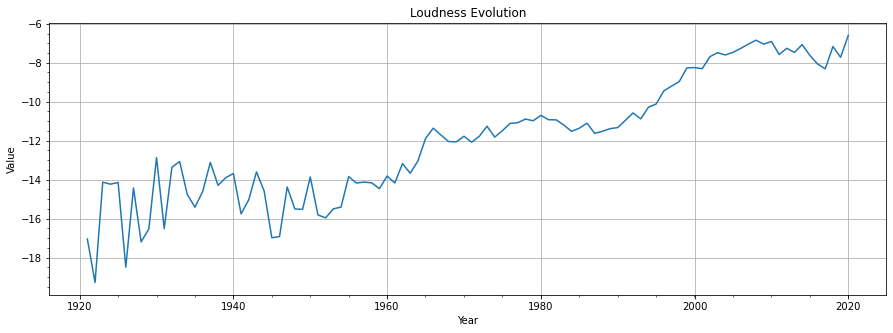

In [18]:
# hacemos un plot para ver la evolución de la variable
plt.figure(figsize=(15,5))
plt.grid()
plt.minorticks_on()
plt.plot(data_loud_s_m)
plt.xlabel('Year') 
plt.ylabel('Value')
plt.title("Loudness Evolution");

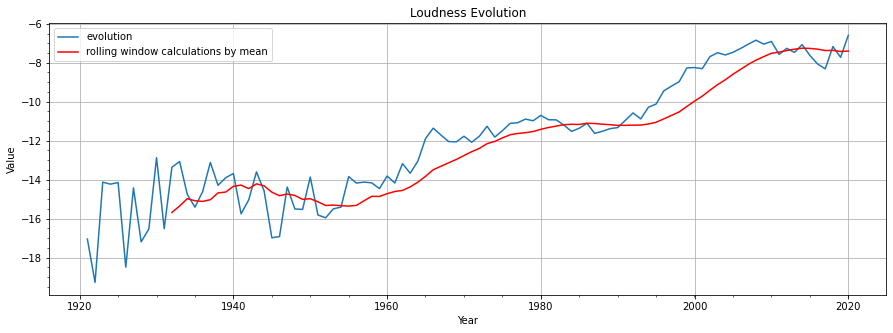

In [19]:
# hacemos un plot para ver la evolución de la variable con un rolling window calculations por la media.
plt.figure(figsize=(15,5))
plt.grid()
plt.minorticks_on()
plt.plot(data_loud_s_m, label="evolution")
plt.plot(data_loud_s_m.rolling(window=12).mean(), c="r", label="rolling window calculations by mean")
plt.xlabel('Year') 
plt.ylabel('Value')
plt.legend()
plt.title("Loudness Evolution");

In [20]:
# mediante la libreria statsmodels, hacemos un seasonal_decompose para separar la estacionalidad , tendencia y el resid
res=seasonal_decompose(data_loud_s_m, model="additive")

<Figure size 720x504 with 0 Axes>

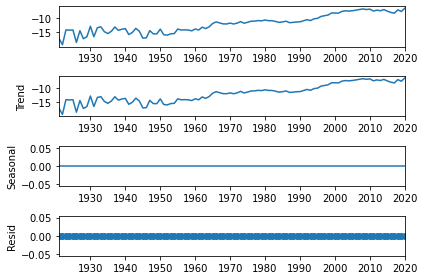

In [21]:
# lo graficamos
plt.figure(figsize=(10,7))
res.plot();

### Time Series Forecasting - ARIMA

In [22]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
model = ARIMA(data_loud_s_m, order=(5,1,0))
model_fit = model.fit()

/Users/borjadelrio/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/borjadelrio/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'
/Users/borjadelrio/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [24]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               loudness   No. Observations:                  100
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -147.019
Date:                Wed, 16 Dec 2020   AIC                            306.038
Time:                        11:05:33   BIC                            321.609
Sample:                    01-01-1921   HQIC                           312.338
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6567      0.078     -8.440      0.000      -0.809      -0.504
ar.L2         -0.4654      0.095     -4.924      0.000      -0.651      -0.280
ar.L3         -0.2093      0.101     -2.073      0.0

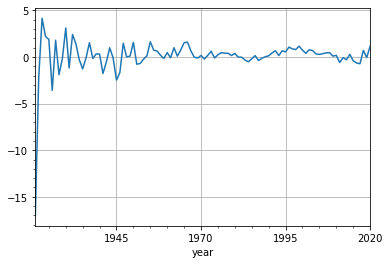

In [25]:
residuals = model_fit.resid
residuals.plot()
plt.grid()
plt.minorticks_on()
plt.show()

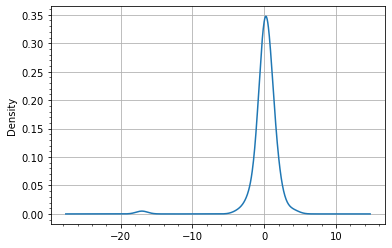

In [26]:
residuals.plot(kind='kde')
plt.grid()
plt.minorticks_on()
plt.show()

In [27]:
# hacemos un .describe para ver la media, desviación estándar
print(residuals.describe())

count    100.000000
mean       0.078198
std        2.026476
min      -17.048667
25%       -0.165600
50%        0.176246
75%        0.687897
max        4.154657
dtype: float64


### evaluate an ARIMA model using a walk-forward validation

In [29]:
# split into train and test sets
X = data_loud_s_m.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [30]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=-11.204829, expected=-11.623467
predicted=-11.346966, expected=-11.519821
predicted=-11.383483, expected=-11.384130
predicted=-11.440880, expected=-11.327479
predicted=-11.384836, expected=-10.955769
predicted=-11.281131, expected=-10.575404
predicted=-11.137060, expected=-10.882701
predicted=-11.043408, expected=-10.282273
predicted=-10.762430, expected=-10.119450
predicted=-10.606490, expected=-9.443818
predicted=-10.176530, expected=-9.200876
predicted=-9.896129, expected=-8.971168
predicted=-9.534741, expected=-8.266410
predicted=-9.054345, expected=-8.247766
predicted=-8.744872, expected=-8.305095
predicted=-8.486156, expected=-7.686640
predicted=-8.180254, expected=-7.485545
predicted=-7.932520, expected=-7.601655
predicted=-7.744698, expected=-7.466159
predicted=-7.614148, expected=-7.265501
predicted=-7.478716, expected=-7.044536
predicted=-7.304128, expected=-6.843804
predicted=-7.133214, expected=-7.046015
predicted=-7.077674, expected=-6.909904
predicted=-6.970328,

In [31]:
# miramos el RMSE
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.619


### Hacemos el gráfico entre el forecast y el actual outcome

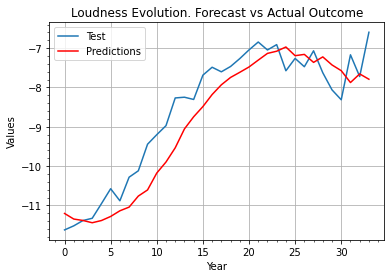

In [32]:
plt.plot(test, label="Test")
plt.plot(predictions, color='red', label="Predictions")
plt.grid()
plt.minorticks_on()
plt.xlabel('Year') 
plt.ylabel('Values')
plt.title("Loudness Evolution. Forecast vs Actual Outcome");
plt.legend()